In [30]:
import numpy as np
import pandas as pd
import dabest
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.patches as patches
from PIL import Image
my_color_palette =  {'NaCl':'#594157','Convulsive PTZ':'#db3021','Control':'#594157','No inj':'#594157','Post-Ictal':'#3287d1'}
channels_order = ["ENT R ventral", "ENT R dorsal", "CA1 R", "CA3 R", "DG R","Sub R", "CA3 L","CA1 L", "DG L","Sub L", "ENT L dorsal", "ENT L ventral"]

In [19]:
# Load single pulse response data 
SP_per_min_PTZ_sz_per_channel = pd.read_pickle('Mice_data/'+'SP_per_min_PTZ_sz_per_channel')

All_sessions = SP_per_min_PTZ_sz_per_channel['Filename'].unique()

In [21]:
# Interval used to calculate mean difference with Baseline
min_dist_Sz = -4 # Start pre-ictal interval in min
max_dist_Sz = 0 # End pre-ictal interval in min

# Keep only conditions to compare
condition_to_compare = ['No inj','Convulsive PTZ']
All_SP_df = SP_per_min_PTZ_sz_per_channel[np.isin(SP_per_min_PTZ_sz_per_channel['Condition'], condition_to_compare) == True]

# Keep only control condition and pulses in the pre-ictal interval
All_SP_df = All_SP_df[(All_SP_df['Distance from Sz [min]'].between(min_dist_Sz, max_dist_Sz)) | (All_SP_df['Condition'] == 'No inj')]

In [22]:
# Arrange data both by channel and conditions
All_SP_df.loc[:,'Channel'] = pd.Categorical(All_SP_df.Channel.tolist(), categories=channels_order)
All_SP_df.loc[:,'Condition'] = pd.Categorical(All_SP_df['Condition'].tolist(), categories=condition_to_compare)
All_SP_df.sort_values(by=['Channel', 'Condition'], inplace=True)
All_SP_df.loc[:,'Channel x Condition'] = All_SP_df['Channel'].astype(str) + ' ' + All_SP_df['Condition'].astype(str)
all_condition = All_SP_df['Channel x Condition'].unique()

def nest_list(flat_list, nesting_factor):
    i = 0
    nested_list = []
    while i < len(flat_list):
        nested_list.append(flat_list[i:i + nesting_factor])
        i += nesting_factor

    return nested_list
    
all_condition_nested = nest_list(all_condition.tolist(), 2)

# For each channel, calculate mean difference after boostraping
multi_groupee = dabest.load(All_SP_df, idx=all_condition_nested, x='Channel x Condition', y='Mean Normalized Sum LL 250ms', resamples=5000)
result_Bootstrap = multi_groupee.mean_diff.statistical_tests

/var/folders/6r/0p67bvdn7t75cb5rwnqb9qdr0000gn/T/ipykernel_20939/4180217783.py:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  All_SP_df.loc[:,'Channel'] = pd.Categorical(All_SP_df.Channel.tolist(), categories=channels_order)
/var/folders/6r/0p67bvdn7t75cb5rwnqb9qdr0000gn/T/ipykernel_20939/4180217783.py:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  All_SP_df.loc[:,'Condition'] = pd.Categorical(All_SP_df['Condition'].tolist(), categories=condition_to_compare)


In [23]:
# Extract the result from result_Bootstrap and save then in a Dataframe
mean_diff = result_Bootstrap["difference"]
IC_95= result_Bootstrap["bca_high"]
IC_05 = result_Bootstrap["bca_low"]
p_value = result_Bootstrap["pvalue_permutation"]
value_df_before = {'Channel': channels_order,'Mean Diff': mean_diff, 'IC 95': IC_95 , 'IC 05':IC_05, 'p_value perm': p_value}
plot_df_before = pd.DataFrame(value_df_before,columns=['Channel', 'Mean Diff', 'IC 95', 'IC 05', 'p_value perm'])

/var/folders/6r/0p67bvdn7t75cb5rwnqb9qdr0000gn/T/ipykernel_20939/3938273765.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('seismic')


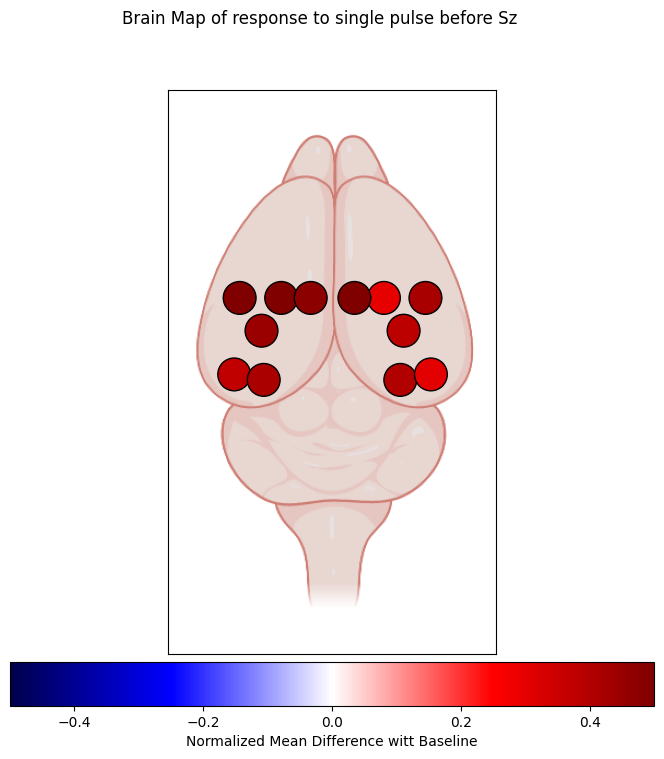

In [24]:
title = 'Brain Map of response to single pulse before Sz'
im = Image.open('Mice_data/Brain_axial.png') #load the brain image as tempalte
# Patch coordinate on the the brain image
Corr_patch = { "ENT R ventral" :(212,265),"ENT R dorsal" :(240,260),'CA1 R': (197, 190) , 'DG R':(170, 190) ,'CA3 R':(235, 190), "Sub R":(215, 220),"CA3 L": (65, 190), "CA1 L":(103, 190), "DG L":(130, 190),"Sub L":(85, 220),
                    "ENT L ventral":(87,265), "ENT L dorsal":(60,260)}

fig2 = plt.figure(title, figsize=(10, 8)).suptitle(title)
gridspec.GridSpec(12, 12)
divnorm = colors.TwoSlopeNorm(vmin=-0.5, vcenter=0,vmax=0.5)
cmap = mpl.cm.get_cmap('seismic')

ax1 = plt.subplot2grid((12, 12), (0, 0), rowspan=11, colspan=12)
ax1.imshow(im)  # Display the brain image
ax1.set_xticks([])
ax1.set_yticks([])

# Create a Circle patch for each brain region
all_patches = []
for Channel in plot_df_before['Channel']:
    Value = float(plot_df_before['Mean Diff'][(plot_df_before['Channel'] == Channel)])
    p_value = float(plot_df_before['p_value perm'][(plot_df_before['Channel'] == Channel)])
    if p_value > 0.005:
        Value = 0
    corr = Corr_patch[Channel]
    color = cmap(divnorm(Value))
    cir = patches.Circle(corr, radius=15, edgecolor='k', facecolor=color)
    all_patches.append(cir)

for patch in all_patches:
    ax1.add_patch(patch)

ax3 =  plt.subplot2grid((12, 12), (11, 1), rowspan=1, colspan=10)
colorbar = mpl.colorbar.ColorbarBase(ax3, orientation='horizontal',cmap=cmap,norm=divnorm, label='Normalized Mean Difference witt Baseline')

In [28]:
# Keep response to single pulse only for one channel
channel_to_plot = 'CA1 R'
SP_channel = SP_per_min_PTZ_sz_per_channel[SP_per_min_PTZ_sz_per_channel['Channel']==channel_to_plot]
All_sessions = SP_channel['Filename'].unique()

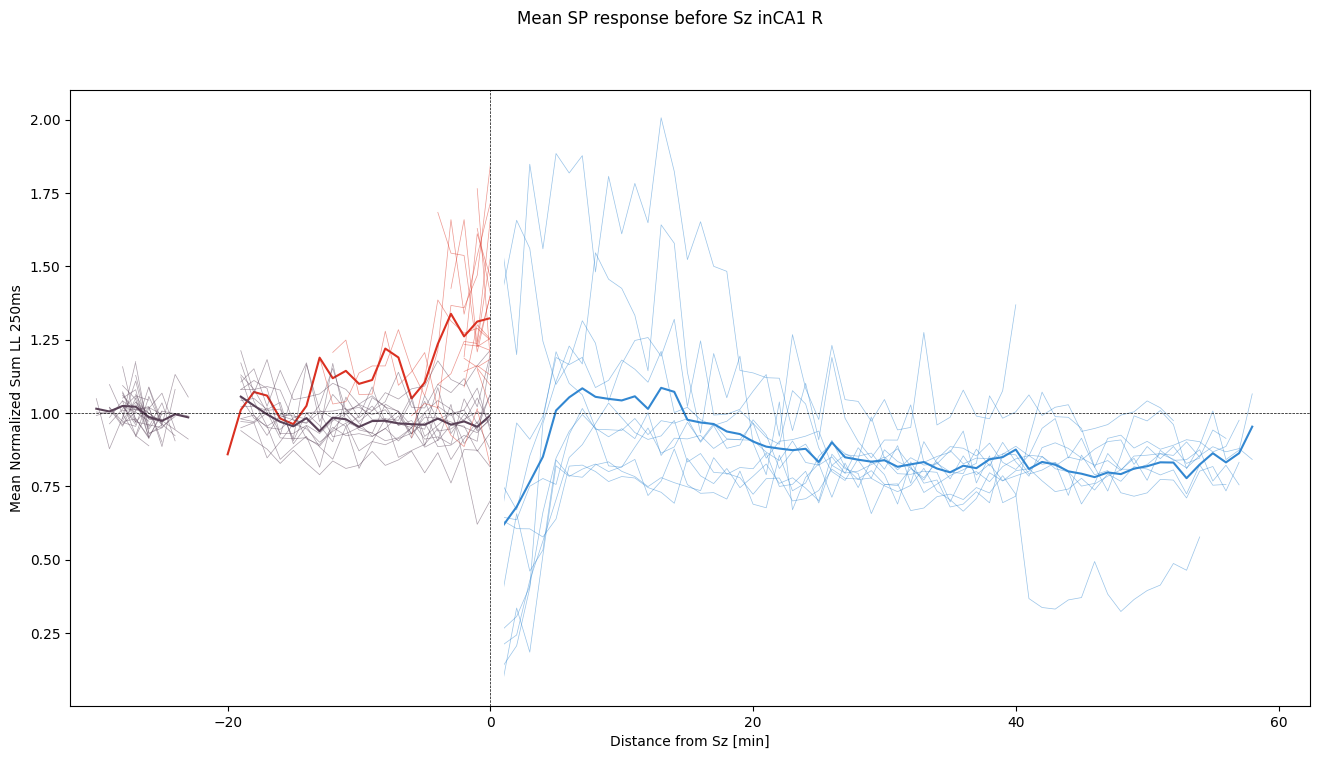

In [34]:
# Plot channel response to single pulse before Sz 
title = 'Mean SP response before Sz in' + channel_to_plot
fig1 = plt.figure(title, figsize=(16, 8)).suptitle(title)
gridspec.GridSpec(12, 12)
ax1 = plt.subplot2grid((12, 12), (0, 0), rowspan=12, colspan=12)
sns.lineplot(ax=ax1, data=SP_channel, x='Distance from Sz [min]', y='Mean Normalized Sum LL 250ms',  errorbar=None, zorder=0, hue="Condition", palette=my_color_palette)
for session in All_sessions:
    df = SP_channel[SP_channel['Filename']==session]
    sns.lineplot(ax=ax1, data=df, x='Distance from Sz [min]', y='Mean Normalized Sum LL 250ms', errorbar=None,zorder=0, lw=0.5, alpha=0.5,hue="Condition", palette=my_color_palette)
ax1.axvline(x=0, color='k', linestyle='--', linewidth=0.5)
ax1.axhline(y=1, color='k', linestyle='--', linewidth=0.5)
ax1.axvspan(0, 1, edgecolor='w', facecolor='w', linestyle="--", alpha=1, lw=0.1, zorder=1)
ax1.set_xlim(left=-32)
ax1.legend([], [], frameon=False)